# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [1]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

File ‘UCI HAR Dataset.zip’ already there; not retrieving.

Archive:  UCI HAR Dataset.zip


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [4]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [5]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [6]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [7]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

/home/namin/.local/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:611: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X


((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

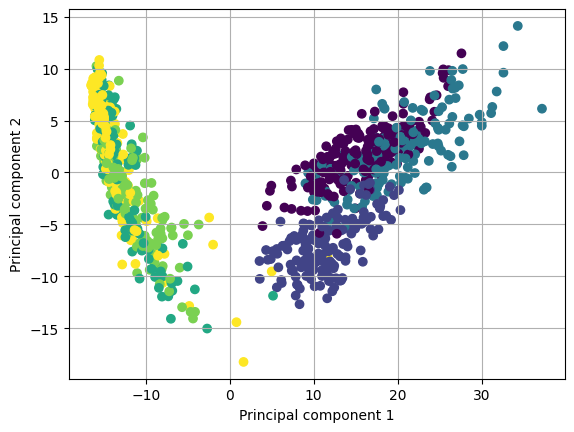

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

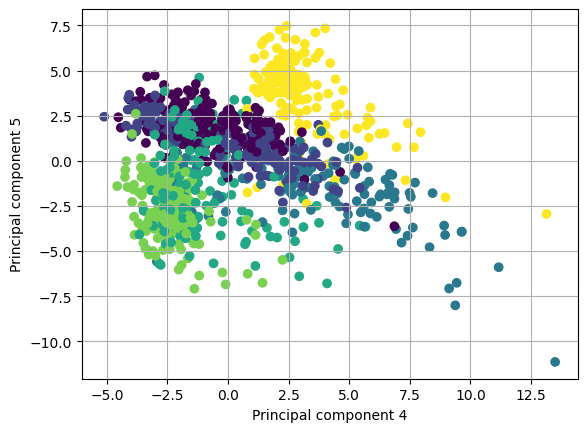

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [12]:
!pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable


In [13]:
import ucimlrepo as uci

In [14]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Prepare data for XGBoost (make sure labels are in integer format)
y_train = (y_train-1).astype(int)
y_test = (y_test-1).astype(int)

# Split training data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

# Define hyperparameter sets
param_sets = [
    {"n_estimators": 50, "max_depth": 3, "learning_rate": 0.1},
    {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.05},
    {"n_estimators": 150, "max_depth": 7, "learning_rate": 0.01},
]

results = []

# Train the model with different hyperparameters
for params in param_sets:
    model = xgb.XGBClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42,
    )
    
    model.fit(X_train_split, y_train_split)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val_split)
    accuracy = accuracy_score(y_val_split, y_val_pred)
    results.append((params, accuracy))
    print(f"Params: {params}, Validation Accuracy: {accuracy:.4f}")

# Select the best parameters (manually or from results)
best_params = {"n_estimators": 100, "max_depth": 5, "learning_rate": 0.05}

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
)
final_model.fit(X_train_pca, y_train)

# Test the model on the test set
y_test_pred = final_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")


/home/namin/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:18:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}, Validation Accuracy: 0.8919


/home/namin/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:19:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}, Validation Accuracy: 0.9259


/home/namin/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:19:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Params: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.01}, Validation Accuracy: 0.9082


/home/namin/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:20:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.8833


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [ ]:
# YOUR CODE HERE
import optuna
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Prepare data for XGBoost
y_train = y_train.astype(int)
y_test = y_test.astype(int)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    # Create and train the model
    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        use_label_encoder=False,
        eval_metric="mlogloss",
        random_state=42
    )
    
    model.fit(X_train_split, y_train_split)

    # Predict and evaluate
    y_val_pred = model.predict(X_val_split)
    accuracy = accuracy_score(y_val_split, y_val_pred)
    return accuracy

# Set up Optuna study to maximize the validation accuracy
study = optuna.create_study(direction='maximize')

# Optimize the hyperparameters
# study.optimize(objective, n_trials=20)  # You can change n_trials for more iterations

# Print the best hyperparameters found
# print("Best hyperparameters:", study.best_params)
# print("Best validation accuracy:", study.best_value)

# Retrain the final model with the best hyperparameters on the full training data
best_params = {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.09090016404762336, 'gamma': 0.10210017904829372, 'min_child_weight': 5} #study.best_params
final_model = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=42,
)
final_model.fit(X_train_pca, y_train)

# Test the model on the test set
y_test_pred = final_model.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy with optimal hyperparameters: {test_accuracy:.4f}")


/home/namin/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-17 17:21:28,001] A new study created in memory with name: no-name-6688d7f4-6b7b-4e39-9847-16f6027562ce
/home/namin/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:21:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Accuracy with optimal hyperparameters: 0.9094


### Conclusion

best_params = {'n_estimators': 198, 'max_depth': 10, 'learning_rate': 0.09090016404762336, 'gamma': 0.10210017904829372, 'min_child_weight': 5}

#### Part1
The choice of max_depth = 5 and learning_rate = 0.05 works better than the other variants. As seen, accuracy decreased with higher learning rates (0.1 and 0.01). Thus, learning have an impact in training stability and performance.

#### Part2
Using Optuna was achieved a better validation accuracy of 94.90% and test accuracy 90,94%. 
Compare with the best validation accuracy %92,59 and test accuracy %88,33 in the previous part. 

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [ ]:
import shap  # noqa: F401

import shap
import matplotlib.pyplot as plt

# долго
explainer = shap.Explainer(final_model, X_train_pca) 
shap_values = explainer(X_train_pca)



100%|===================| 44101/44112 [27:55<00:00]        

In [18]:
print(shap_values, X_train_pca)

.values =
array([[[-1.60547817e+00, -1.82435370e+00, -1.37470828e+00,
          1.53859347e+00,  1.34485681e+00,  6.67300545e-01],
        [ 1.95322200e-01, -8.01567938e-01,  2.74636367e-02,
         -4.91774411e-03, -3.22055868e-03,  3.41054872e-04],
        [-2.19760939e-01,  7.33220289e-02, -7.15746403e-04,
         -2.30636578e-03, -4.21788041e-02,  2.90582100e-01],
        ...,
        [ 4.46997772e-04,  0.00000000e+00, -5.86599878e-04,
         -1.30584037e-02,  8.38250418e-03,  0.00000000e+00],
        [ 9.64764245e-03,  1.52606322e-03, -7.63743799e-02,
         -2.83579124e-03,  5.71436531e-03,  0.00000000e+00],
        [-2.37224549e-04,  0.00000000e+00,  2.03726534e-04,
         -1.84062959e-03,  2.45834537e-03,  0.00000000e+00]],

       [[-1.81207422e+00, -1.20342418e+00, -1.55911796e+00,
          1.72845146e+00,  1.68778806e+00,  5.80132808e-01],
        [ 2.02098997e-01, -6.27725546e-01,  2.74137657e-02,
         -3.52708873e-03,  4.59124072e-04, -5.32397977e-04],
       

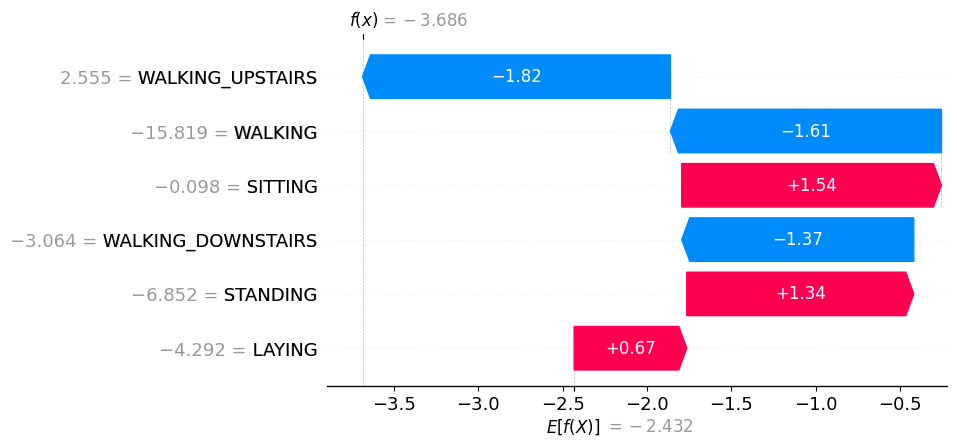

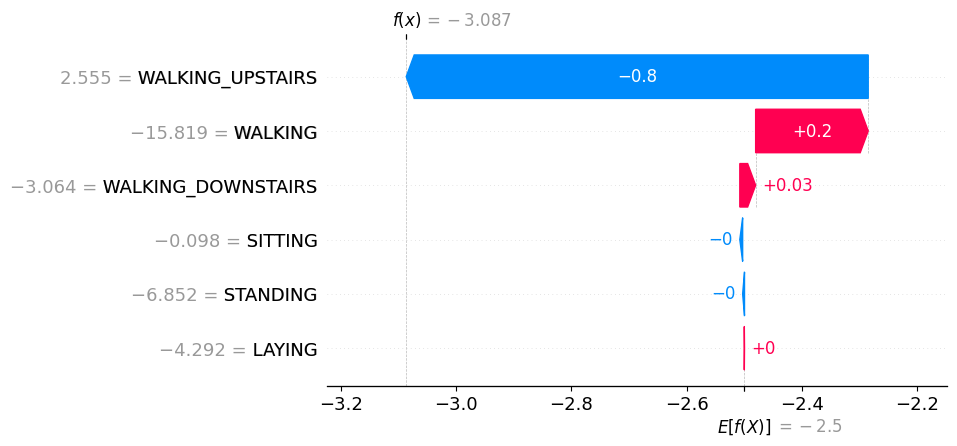

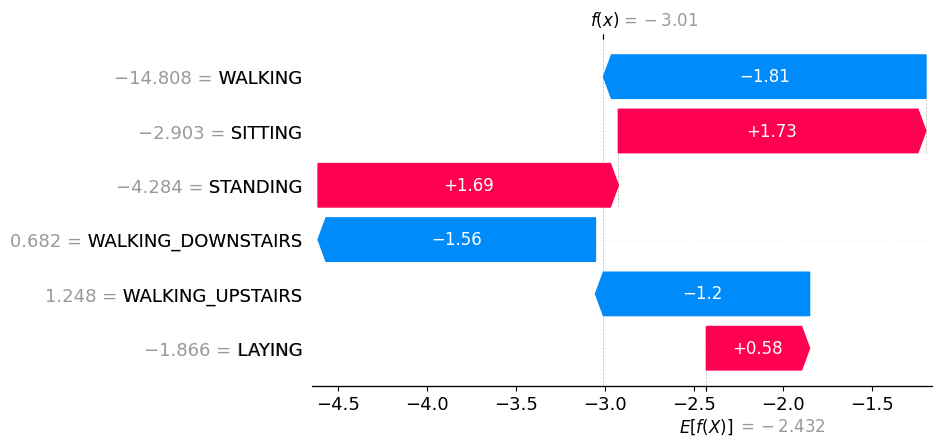

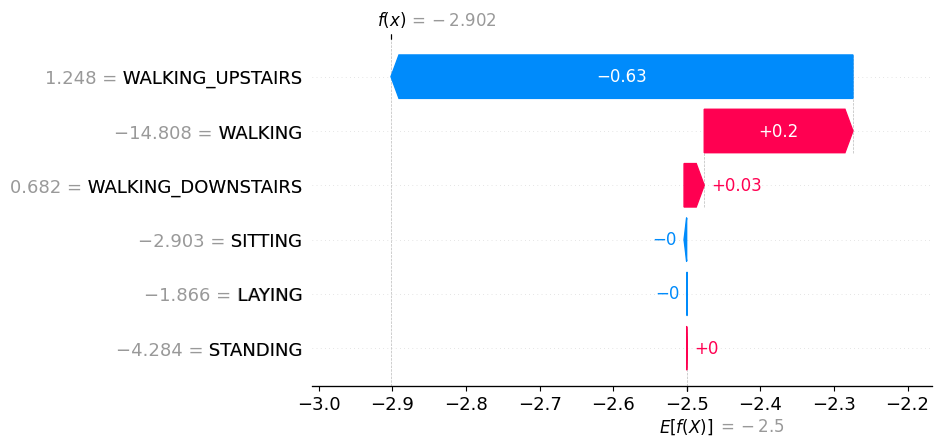

In [21]:
# shap.summary_plot(shap_values, X_train_pca, features_names=activity_labels.values())

# Plot the summary with custom feature names
# del (shap_values.feature_names)

# shap.summary_plot(shap_values, X_train_pca)
# shap.summary_plot(shap_values, X_train_pca, plot_type="bar")

for sample_idx in range(min(2,len(shap_values))):
    for output_idx in range(min(2,len(shap_values[sample_idx].base_values))):
        shap_values_for_sample = shap_values[sample_idx, output_idx]
        base_value = shap_values[sample_idx].base_values[output_idx]
        
        shap.plots.waterfall(shap.Explanation(
            values=shap_values_for_sample.values,
            base_values=base_value,
            data=X_train_pca[sample_idx],
            feature_names=activity_labels.values()
))

### Conclusion

Your thoughts about the plots and model behaviour:

...